# Creating, Evaluating, and Deploying a Fraud Detection System

## Introduction

In this notebook, we'll demonstrate the Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a fraud detection system that relies on ML algorithms trained on historical data consisting of previous examples of fraud in order to understand the characteristic patterns of the fraudulent events to recognize them once they recur.

The summary of main steps we take in this notebook are as following:

1. Install custom libraries
2. Load and process the data
3. Understand the data using exploratory data analysis
4. Train a machine learning model using Scikit-Learn and MLflow
5. Save and register the best performing machine learning model
6. Load the machine learning model for scoring and make predictions

#### Prerequisites
- Have a lakehouse added to this notebook. We will be downloading data from a public blob, and storing that in the lakehouse. 

## Step 1: Install Custom Libraries
When developing a machine learning model or doing ad-hoc data analysis, we may need to quickly install a custom library for your Apache Spark session. To do this, we have two choices. 

1. We can use the in-line installation capabilities (e.g., pip, conda, etc.) to quickly get started with new libraries. In this notebook, we'll use `imblearn` which first needs to be installed.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, we can install the required libraries in the workspace. Navigate to the workspace setting as shown below and then click on Library management.

<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement2.png"  width="45%" height="10%">
<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement1.png"  width="45%" height="10%"> 


We can then select how to install the required libraries, e.g., add from PyPi, add from .yml file, etc. Since we are using PyPi, we click on + Add from PyPi and then select the desired libraries and their corresponding versions from the drop down and then click on the Apply. This will automatically install all selected libraries in the workspace.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/librarymanagement3.png"  width="40%" height="10%">

#### Introduction to SMOTE

The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) is the most widely used approach to synthesize new samples for the minority class. You can read more about SMOTE [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [here](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn).

In order to install Imbalanced-learn (imported as imblearn) which is a library for SMOTE, we will proceed with the first approach in Step 1.


In [ ]:
# Install imblearn for SMOTE using pip
%pip install imblearn

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 23.2
[notice] To update, run: /nfs4/pyenv-9b9b582b-c6fa-4634-a3b8-6e6f7a56aa25/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the Data
The fraud detection dataset contains credit card transactions made by European cardholders in September 2013 over the course of two days. The dataset only contains numerical features, which is the result of a Principal Component Analysis (PCA) transformation that was done on the original features. The only features that haven't been transformed with PCA are "Time" and "Amount". In order to protect confidentiality, we can't provide the original features or more background information about the dataset.

- The features "V1, V2, V3, …, V28" are the principal components obtained with PCA.
- The feature "Time" contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature "Amount" is the transaction amount. This feature can be used for example-dependent cost-sensitive learning.
- The column "Class" is the response (target) variable and take the value 1 for fraud and 0 otherwise.

Note that out of the 284,807 transactions, only 492 are fraudulent. Therefore, the minority class (fraud) only accounts for around 0.172% of the data which makes the dataset highly imbalanced.

- creditcard.csv

|"Time"|"V1"|"V2"|"V3"|"V4"|"V5"|"V6"|"V7"|"V8"|"V9"|"V10"|"V11"|"V12"|"V13"|"V14"|"V15"|"V16"|"V17"|"V18"|"V19"|"V20"|"V21"|"V22"|"V23"|"V24"|"V25"|"V26"|"V27"|"V28"|"Amount"|"Class"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|-1.3598071336738|-0.0727811733098497|2.53634673796914|1.37815522427443|-0.338320769942518|0.462387777762292|0.239598554061257|0.0986979012610507|0.363786969611213|0.0907941719789316|-0.551599533260813|-0.617800855762348|-0.991389847235408|-0.311169353699879|1.46817697209427|-0.470400525259478|0.207971241929242|0.0257905801985591|0.403992960255733|0.251412098239705|-0.018306777944153|0.277837575558899|-0.110473910188767|0.0669280749146731|0.128539358273528|-0.189114843888824|0.133558376740387|-0.0210530534538215|149.62|"0"|
|0|1.19185711131486|0.26615071205963|0.16648011335321|0.448154078460911|0.0600176492822243|-0.0823608088155687|-0.0788029833323113|0.0851016549148104|-0.255425128109186|-0.166974414004614|1.61272666105479|1.06523531137287|0.48909501589608|-0.143772296441519|0.635558093258208|0.463917041022171|-0.114804663102346|-0.183361270123994|-0.145783041325259|-0.0690831352230203|-0.225775248033138|-0.638671952771851|0.101288021253234|-0.339846475529127|0.167170404418143|0.125894532368176|-0.00898309914322813|0.0147241691924927|2.69|"0"|


**By defining below parameters, we can apply this notebook on different datasets easily.**

In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually

TARGET_COL = "Class"  # target column name
IS_SAMPLE = False  # if True, use only <SAMPLE_ROWS> rows of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_FOLDER = "Files/fraud-detection/"  # folder with data files
DATA_FILE = "creditcard.csv"  # data file name

EXPERIMENT_NAME = "aisample-fraud"  # mlflow experiment name

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 10, Finished, Available)

### Download dataset and Upload to lakehouse

The following code will download a publicly available version of the the dataset and then store it in a Fabric Lakehouse.

**Please add a lakehouse to the notebook before running it. Failure to do so will result in an error.**

Instructions to add a lakehouse to the notebook can be found [here](https://aka.ms/fabric/addlakehouse).

In [ ]:
if not IS_CUSTOM_DATA:
    # Download data files into lakehouse if not exist
    import os, requests

    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection"
    fname = "creditcard.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Downloaded demo data files into lakehouse.")


StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 11, Finished, Available)

Downloaded demo data files into lakehouse.


We start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()


StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 12, Finished, Available)

### Setup the MLflow experiment tracking

Experiment tracking is the process of saving all experiment related information that we care about for every experiment we run. This is important because for some experiments, we can easily observe that there is no way we will be able to get better results. Therefore, we will be better off simply stopping them and trying a new experiment. 

Synapse Data Science in Microsoft Fabric includes autologging, which significantly reduces the amount of code required to automatically log the parameters, metrics, and items of a machine learning model during training. This feature extends MLflow autologging capabilities and is deeply integrated into the Synapse Data Science in Microsoft Fabric experience. Using autologging, we can easily track and compare the performance of different models and experiments without the need for manual tracking. Further information about how to perform autologging can be found [here](https://aka.ms/fabric-autologging).

In [ ]:
# Setup mlflow for experiment tracking
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # disable mlflow autologging

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 13, Finished, Available)

2023/07/17 05:29:29 INFO mlflow.tracking.fluent: Experiment with name 'aisample-fraud' does not exist. Creating a new experiment.


### Read raw date data from the lakehouse

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", True)
    .load(f"{DATA_FOLDER}/raw/{DATA_FILE}")
    .cache()
)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 14, Finished, Available)

## Step 3: Exploratory Data Analysis

We can explore using the `display` command to view high-level statistics of the dataset. You can learn more about visualization in Microsoft Fabric [here](https://aka.ms/fabric/visualization).

In [ ]:
display(df)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 15, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3138d659-5ac5-4402-b84d-cb02bc7e0952)

In [ ]:
# Print dataset basic information
print("records read: " + str(df.count()))
print("Schema: ")
df.printSchema()

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 16, Finished, Available)

records read: 284807
Schema: 
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable =

We need to cast the columns into the correct types.

In [ ]:
import pyspark.sql.functions as F

df_columns = df.columns
df_columns.remove(TARGET_COL)

# Ensure the TARGET_COL is the last column
df = df.select(df_columns + [TARGET_COL]).withColumn(TARGET_COL, F.col(TARGET_COL).cast("int"))

if IS_SAMPLE:
    df = df.limit(SAMPLE_ROWS)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 17, Finished, Available)

In [ ]:
df_pd = df.toPandas() # Convert Spark dataframe to Pandas dataframe for easier visualization and processing

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 18, Finished, Available)

In [ ]:
# The distribution of classes in the dataset

print('No Frauds', round(df_pd['Class'].value_counts()[0]/len(df_pd) * 100,2), '% of the dataset')
print('Frauds', round(df_pd['Class'].value_counts()[1]/len(df_pd) * 100,2), '% of the dataset')

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 19, Finished, Available)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


This shows that most of the transactions are non-fraudulent and therefore pre-processing is required prior to train any model to avoid any overfitting.

**Distribution of fraudulent versus non-fraudulent transactions.**

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 20, Finished, Available)

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

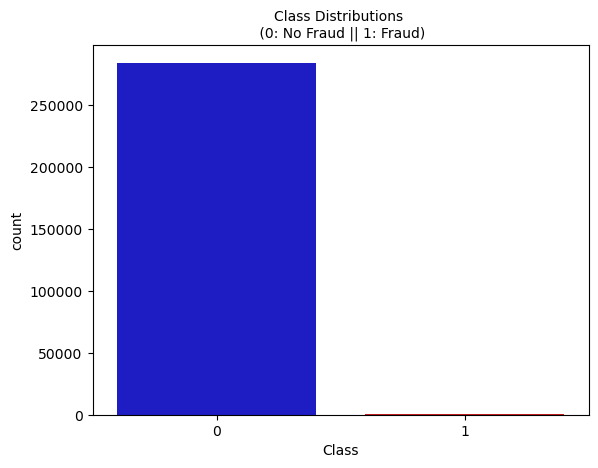

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df_pd, palette=colors) 
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)

This clearly shows how imbalanced the dataset is.

**Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the transaction amount using Box plots.**

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 21, Finished, Available)

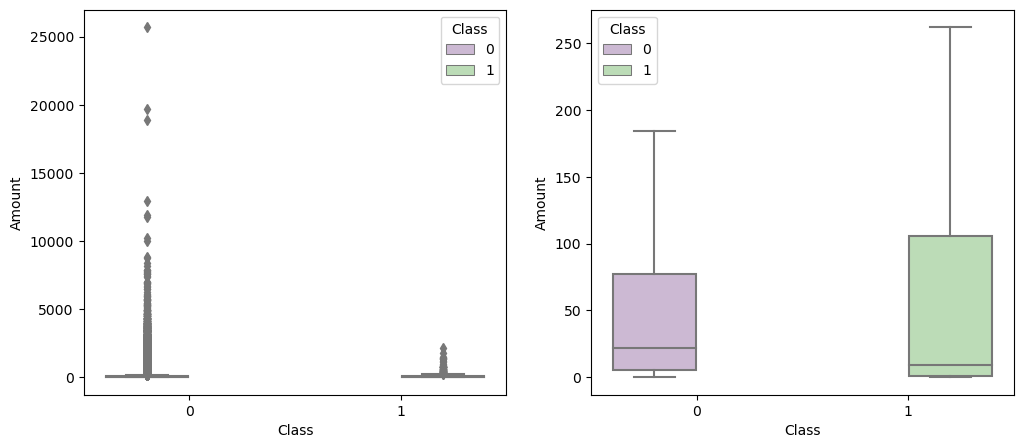

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=True) # Remove outliers from the plot
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df_pd, palette="PRGn", showfliers=False) # Kepp outliers from the plot
plt.show()

Note that when the data is highly imbalanced, these plots may not demonstrate accurate insights because they will be affected by the imbalance between the classes. An alternative solution is to tackle the imbalance issue first and then create the same plots for more accurate insights.

## Step 4: Model Training and Evaluation

In this section, we train a LightGBM model to classify the fraud transactions. Note that we'll train the LightGBM model on both the imbalanced dataset as well as the balanced dataset (via SMOTE) and compare their performances.

Prior to start the training, we split the data to the training and test datasets. Note that SMOTE should only be applied to the training dataset and we must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

### Prepare training and test datasets

In [ ]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_pd, test_size=0.15)
feature_cols = [c for c in df_pd.columns.tolist() if c not in [TARGET_COL]]


StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 22, Finished, Available)

### Apply SMOTE to the training data to synthesize new samples for the minority class

In [ ]:
# Apply SMOTE to the training data
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

X = train[feature_cols]
y = train[TARGET_COL]
print("Original dataset shape %s" % Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("Resampled dataset shape %s" % Counter(y_res))

new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 23, Finished, Available)

Original dataset shape Counter({0: 241667, 1: 418})
Resampled dataset shape Counter({0: 241667, 1: 241667})


### Model Training and Machine Learning Experiments

Apache Spark in Microsoft Fabric enables machine learning with big data, providing the ability to obtain valuable insight from large amounts of structured, unstructured, and fast-moving data. There are several options when training machine learning models using Apache Spark in Microsoft Fabric: Apache Spark MLlib, SynapseML, and various other open-source libraries. You can learn about how to train machine learning models in Microsoft Fabric [here](https://aka.ms/fabric/MLTrain). 

A machine learning experiment is the primary unit of organization and control for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the process of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables to organize all the the required  components of a specific machine learning experiment as well as reproducing past results (easily) using saved experiments. You can learn more about machine learning experiments in Microsoft Fabric [here](https://aka.ms/synapse-experiment).

Update the MLflow autologging configuration to track additional metrics, parameters, files by setting  `exclusive=False`.

In [ ]:
mlflow.autolog(exclusive=False)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 24, Finished, Available)

2023/07/17 05:29:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/07/17 05:29:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/07/17 05:29:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


**Train the model using LightGBM.**

We train using both the imbalanced dataset as well as the balanced dataset (via SMOTE) and then compare their performances.

In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier(objective="binary") # imbalanced dataset
smote_model = lgb.LGBMClassifier(objective="binary") # balanced dataset

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 25, Finished, Available)

2023/07/17 05:29:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


In [ ]:
# Train LightGBM for both imbalanced and balanced datasets and define the evaluation metrics

print("Start training with imbalanced data:\n")
with mlflow.start_run(run_name="raw_data") as raw_run:
    model = model.fit(
        train[feature_cols],
        train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

print(f"\n\nStart training with balanced data:\n")
with mlflow.start_run(run_name="smote_data") as smote_run:
    smote_model = smote_model.fit(
        new_train[feature_cols],
        new_train[TARGET_COL],
        eval_set=[(test[feature_cols], test[TARGET_COL])],
        eval_metric="auc",
        callbacks=[
            lgb.log_evaluation(10),
        ],
    )

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 26, Finished, Available)

Start training with imbalanced data:

[10]	valid_0's auc: 0.816244	valid_0's binary_logloss: 0.0176888
[20]	valid_0's auc: 0.840098	valid_0's binary_logloss: 0.0262594
[30]	valid_0's auc: 0.844251	valid_0's binary_logloss: 0.0381959
[40]	valid_0's auc: 0.763075	valid_0's binary_logloss: 0.0612438
[50]	valid_0's auc: 0.748436	valid_0's binary_logloss: 0.0775722
[60]	valid_0's auc: 0.697948	valid_0's binary_logloss: 0.0656759
[70]	valid_0's auc: 0.717529	valid_0's binary_logloss: 0.195873
[80]	valid_0's auc: 0.715519	valid_0's binary_logloss: 0.102958
[90]	valid_0's auc: 0.666755	valid_0's binary_logloss: 0.136029
[100]	valid_0's auc: 0.654642	valid_0's binary_logloss: 0.100774


Start training with balanced data:

[10]	valid_0's auc: 0.972668	valid_0's binary_logloss: 0.224593
[20]	valid_0's auc: 0.973589	valid_0's binary_logloss: 0.0962729
[30]	valid_0's auc: 0.973279	valid_0's binary_logloss: 0.0485668
[40]	valid_0's auc: 0.973477	valid_0's binary_logloss: 0.0277949
[50]	valid_0's auc

2023/07/17 05:30:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


**Determine the feature importance for training with imbalanced dataset.**

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 27, Finished, Available)

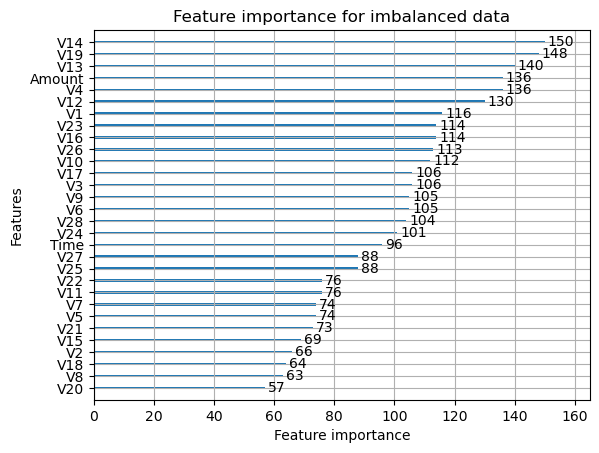

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    importance = lgb.plot_importance(
        model, title="Feature importance for imbalanced data"
    )
    importance.figure.savefig("feauture_importance.png")
    mlflow.log_figure(importance.figure, "feature_importance.png")

**Determine feature importance for training with balanced (via SMOTE) dataset.**

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 28, Finished, Available)

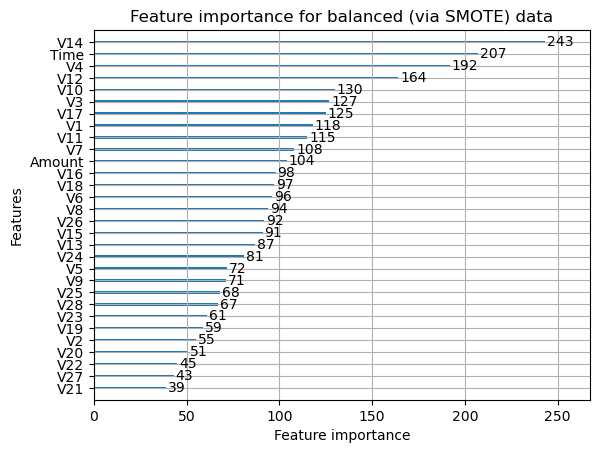

In [ ]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    smote_importance = lgb.plot_importance(
        smote_model, title="Feature importance for balanced (via SMOTE) data"
    )
    smote_importance.figure.savefig("feauture_importance_smote.png")
    mlflow.log_figure(smote_importance.figure, "feauture_importance_smote.png")

Comparison of the above plots clearly demonstrates that the importance of features is drastically different between imbalanced versus balanced datasets.

#### Model Evaluation

Below, we define a function that performs predictions and converts the prediction results into a Spark DataFrame so that we can later compute model statistics using [SynapseML](https://aka.ms/fabric/SynapseEval).

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

def prediction_to_spark(model, test):
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test[TARGET_COL].tolist(), predictions.tolist()))
    dataColumns = [TARGET_COL, "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 29, Finished, Available)

Below we perform predictions and compute the metrics for the model trained with raw data (imbalanced) and the model trained with balanced (via SMOTE) data.

In [ ]:
predictions = prediction_to_spark(model, test)
smote_predictions = prediction_to_spark(smote_model, test)
predictions.limit(10).toPandas()

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 30, Finished, Available)

,Class,prediction
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [ ]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(predictions)

smote_metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(smote_predictions)
display(metrics)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 31, Finished, Available)

SynapseWidget(Synapse.DataFrame, 39cb6f96-1589-49db-a03d-b4eb4869c55b)

#### Confusion Matrix
We use the confusion matrix in order to summarize the performances of the trained machine learning models on the test data. The matrix displays the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) produced by the model on the test data. Note that for binary classification, the matrix will be of a 2X2 table, For multi-class classification, the matrix shape will be equal to the number of classes i.e for n classes it will be a nXn table. 

In [ ]:
# Collect confusion matrix value
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
smote_cm = smote_metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 32, Finished, Available)

[[4.252e+04 1.280e+02]
 [3.300e+01 4.100e+01]]


StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 33, Finished, Available)

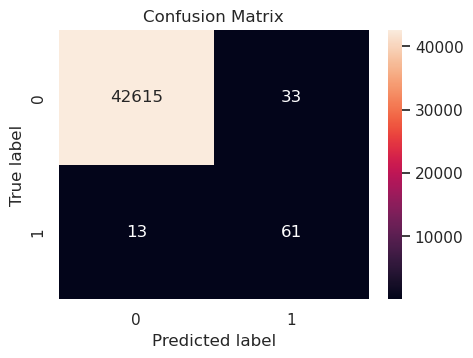

In [ ]:
# Plot confusion matrix
import seaborn as sns

def plot(cm):
    """
    Plot the confusion matrix.
    """
    sns.set(rc={"figure.figsize": (5, 3.5)})
    ax = sns.heatmap(cm, annot=True, fmt=".20g")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

with mlflow.start_run(run_id=smote_run.info.run_id):
    ax = plot(smote_cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 34, Finished, Available)

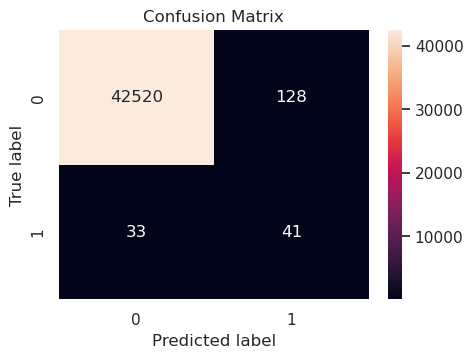

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    ax = plot(cm)
    mlflow.log_figure(ax.figure, "ConfusionMatrix.png")

#### Receiver Operating Characteristic Area Under the Curve and Area Under the Precision-Recall Curve

The Area Under the Curve Receiver Operating Characteristic (AUC-ROC) measure is widely used to assess the performance of binary classifiers. However, sometimes, it is more appropriate to evaluate your classifier based on measuring the Area Under the Precision-Recall Curve (AUPRC). AUC-ROC is a chart that visualizes the trade-off between true positive rate (TPR) and false positive rate (FPR) whereas AUPRC is a curve that combines precision (PPV) and Recall (TPR) in a single visualization.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """

    # Initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol=TARGET_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # Calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"The AUROC is: {auroc:.4f}")

    # Calculate AUPRC, baseline positive rate (0.172% in the data)
    auprc = _evaluator("areaUnderPR")
    print(f"The AUPRC is: {auprc:.4f}")

    return auroc, auprc


StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 35, Finished, Available)

**Log the AUC-ROC and AUPRC metrics for model that is trained on the imbalanced dataset.**

In [ ]:
with mlflow.start_run(run_id=raw_run.info.run_id):
    auroc, auprc = evaluate(predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "None", "DATA_FILE": DATA_FILE})

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 36, Finished, Available)

The AUROC is: 0.7755
The AUPRC is: 0.1889


**Log the AUC-ROC and AUPRC metrics for the model that is trained on the balanced (via SMOTE) dataset.**

In [ ]:
with mlflow.start_run(run_id=smote_run.info.run_id):
    auroc, auprc = evaluate(smote_predictions)
    mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
    mlflow.log_params({"Data_Enhancement": "SMOTE", "DATA_FILE": DATA_FILE})

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 37, Finished, Available)

The AUROC is: 0.9118
The AUPRC is: 0.5921


As shown in the image below, any experiment with its respective name is logged and we will be able to track its parameters and performance metrics. We can also see that the models performs much better on the balanced dataset, since a higher AUROC indicates that the model is better at predicting 0 classes as 0 and 1 classes as 1.


<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/fraud-mlflow.png"  width="45%" height="10%">
<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Credit_Card_Fraud_Detection/fraud-logging.png"  width="45%" height="10%"> 




## Step 5: Register the Model

Use MLflow to register the models trained on both the imbalanced and balanced (via SMOTE) datasets.

In [ ]:
# Register the model
registered_model_name = f"{EXPERIMENT_NAME}-lightgbm"

raw_model_uri = "runs:/{}/model".format(raw_run.info.run_id)
mlflow.register_model(raw_model_uri, registered_model_name)

smote_model_uri = "runs:/{}/model".format(smote_run.info.run_id)
mlflow.register_model(smote_model_uri, registered_model_name)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 38, Finished, Available)

Successfully registered model 'aisample-fraud-lightgbm'.
2023/07/17 05:30:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-fraud-lightgbm, version 1
Created version '1' of model 'aisample-fraud-lightgbm'.
Successfully registered model 'aisample-fraud-lightgbm'.
2023/07/17 05:30:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-fraud-lightgbm, version 2
Created version '2' of model 'aisample-fraud-lightgbm'.


<ModelVersion: creation_timestamp=1689571849691, current_stage='None', description='', last_updated_timestamp=1689571849691, name='aisample-fraud-lightgbm', run_id='c3f7aa87-fa23-4713-a2f1-0640d90e1a0c', run_link='', source='abfss://d2a85142-94be-4d6a-b988-13da340ac6b3@olswestch7x2f49bqoy8a5n7.dfs.core.windows.net/2771826d-e977-4876-a6e6-344430e5dc18/7522f1b1-9436-400f-b0a7-e6cf9b6df5fa/artifacts', status='READY', status_message='', tags={}, user_id='', version='2'>

## Step 6: Save the Prediction Results

Microsoft Fabric allows users to operationalize machine learning models with a scalable function called ```PREDICT```, which supports batch scoring in any compute engine.

We can generate batch predictions directly from the Microsoft Fabric notebook or from a given model's item page. You can learn more about ```PREDICT``` and how to use it within Microsoft Fabric [here](https://aka.ms/fabric-predict).

In this section, we'll deploy the model and save the prediction results.

In [ ]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-lightgbm",
    modelVersion=2,
)

test_spark = spark.createDataFrame(data=test, schema=test.columns.to_list())

batch_predictions = model.transform(test_spark)

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 39, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [ ]:
# Save the predictions into the lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(f"{DATA_FOLDER}/predictions/batch_predictions")

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 40, Finished, Available)

In [ ]:
# Determine the entire runtime
batch_predictions.limit(5).toPandas()
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 563940d7-ec44-4e7f-9d02-3f4cc0d218d1, 41, Finished, Available)

Full run cost 100 seconds.
